## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

**<font color='red'> Note: The visualization portion of the code is replaced with a simpler code - the code suggested originally has problems executing.</font>**

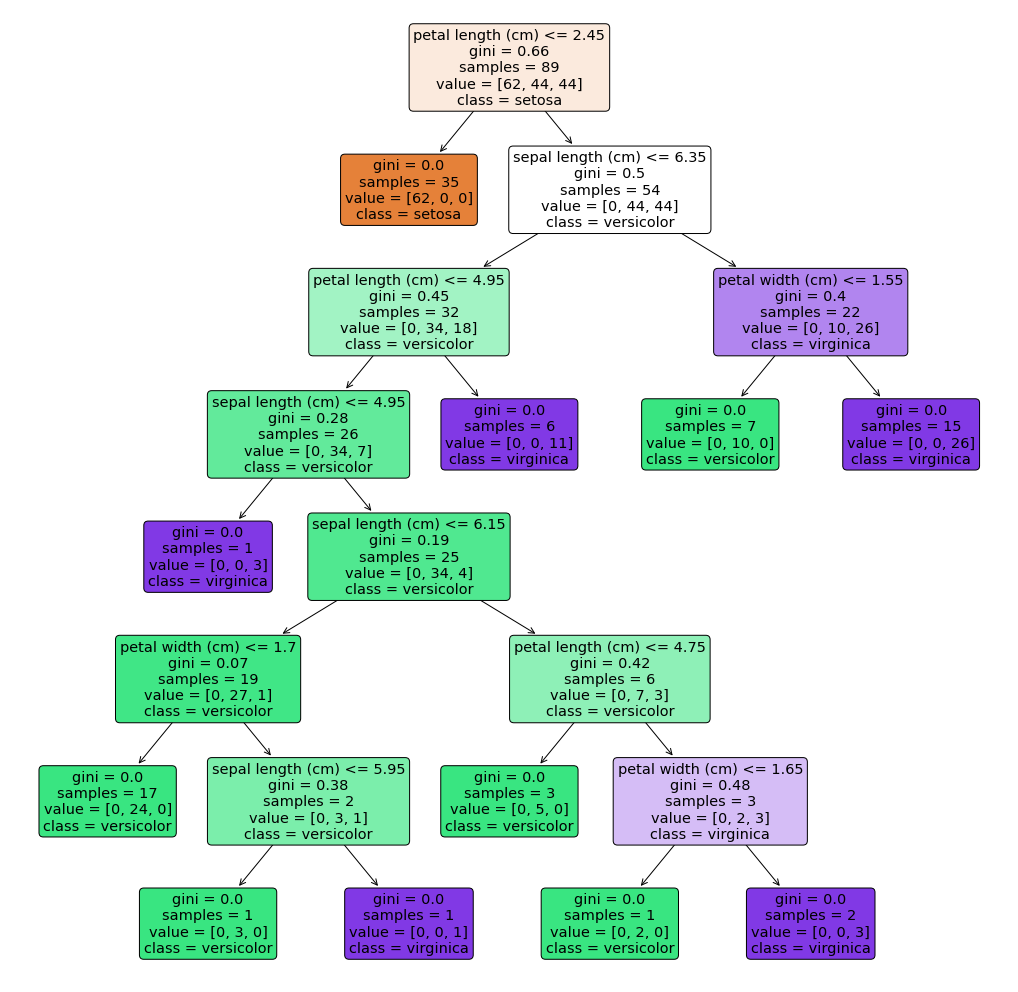

In [2]:
# use tree.plot_tree for visualization

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))  # customize according to the size of your tree
_ = tree.plot_tree(estimator, feature_names = iris.feature_names, class_names = iris.target_names, 
                   rounded = True, proportion = False, precision = 2, filled = True)
plt.show()

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [3]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
sns.set(style = 'whitegrid', font_scale = 1.8)


import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(file_path)
df.head(10)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
5,1000000006,10.0,female,1966.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,3.0,1.000000e+09,43.0,NaN,2020-01-31,2020-02-19,NaN,released
6,1000000007,11.0,male,1995.0,20s,Korea,Seoul,Jongno-gu,NaN,contact with patient,3.0,1.000000e+09,0.0,NaN,2020-01-31,2020-02-10,NaN,released
7,1000000008,13.0,male,1992.0,20s,Korea,Seoul,etc,NaN,overseas inflow,1.0,NaN,0.0,NaN,2020-02-02,2020-02-24,NaN,released
8,1000000009,19.0,male,1983.0,30s,Korea,Seoul,Songpa-gu,NaN,overseas inflow,2.0,NaN,68.0,NaN,2020-02-05,2020-02-21,NaN,released
9,1000000010,21.0,female,1960.0,60s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,3.0,1.000000e+09,6.0,NaN,2020-02-05,2020-02-29,NaN,released


In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
# counts of response variable values including nulls--> this is our target!
df.state.value_counts(dropna = False)

isolated    1791
released     307
NaN           88
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
from datetime import date
current_year = date.today().year

df['n_age'] = current_year - df['birth_year']
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,57.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,34.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,57.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,29.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [10]:
df['disease'].unique()

array([nan, True], dtype=object)

In [11]:
df['disease'].fillna(0, inplace = True)

# to replace True simply multiply by 1 --> Python counts True, False as 1, 0 and performs mathematical operations accordingly!
df['disease'] *= 1
df['disease'].unique()

array([0, 1], dtype=object)

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**
 
 **<font color='red'> Note: There is an error in the column names listed here - 'global_number' is actually 'global_num'. </font>**

In [12]:
feat_list = ['global_num','birth_year','infection_order','infected_by', 'contact_number']

for item in feat_list:
    feat_mean = round(df[item].mean(), 2)
    df[item].fillna(feat_mean, inplace = True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          2218 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          2218 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             2218 non-null   object 
 9   infection_case      1163 non-null   object 
 10  infection_order     2218 non-null   float64
 11  infected_by         2218 non-null   float64
 12  contact_number      2218 non-null   float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**
 
 **<font color='red'> Note: It is advisable to drop the unnecessary features before filling the missing values. Therefore, we will drop the date columns here. We will drop 'patient_id' (non-informative), and 'birth_year' and 'age' (replaced by 'n_age'), as well.</font>**

In [13]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state', 'n_age'],
      dtype='object')

In [14]:
# drop unnecessary features

df = df.drop(['symptom_onset_date', 'confirmed_date', 'released_date', 
              'deceased_date', 'patient_id', 'birth_year', 'age'], axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       2218 non-null   float64
 1   sex              2073 non-null   object 
 2   country          2218 non-null   object 
 3   province         2218 non-null   object 
 4   city             2153 non-null   object 
 5   disease          2218 non-null   object 
 6   infection_case   1163 non-null   object 
 7   infection_order  2218 non-null   float64
 8   infected_by      2218 non-null   float64
 9   contact_number   2218 non-null   float64
 10  state            2130 non-null   object 
 11  n_age            1764 non-null   float64
dtypes: float64(5), object(7)
memory usage: 208.1+ KB


The remaining features which have missing values are: 'sex', 'city', 'infection_case', 'state', and 'n_age'.

**Important: The feature 'state' is our target. Therefore, we cannot fill its missing values! Instead, we will use the data with unknown 'state' values for predictions with the model which is trained and validated with the data with known 'state' value.**

- Filling the missing values in the feature 'sex'

In [15]:
# check value count including nulls

feat = 'sex'
print(df[feat].value_counts(dropna = False))

female    1171
male       902
NaN        145
Name: sex, dtype: int64


In [16]:
# obtain feature count in percentages excluding nulls

feat_count = df[feat].value_counts(normalize = True)
print(feat_count)

female    0.564882
male      0.435118
Name: sex, dtype: float64


In [17]:
# impute the missing value by using weighted random selection from the two choices

list_feat = [feat_count.index[0], feat_count.index[1]]
weights_feat = [feat_count.values[0], feat_count.values[1]]

print(list_feat)
print(weights_feat)

['female', 'male']
[0.5648818137964303, 0.4351181862035697]


In [18]:
from numpy.random import choice

df.loc[df[feat].isna(), feat] = choice(list_feat, p = weights_feat, size = df[feat].isna().sum())

In [19]:
# check value count again including nulls

print(df[feat].value_counts(dropna = False))

female    1246
male       972
Name: sex, dtype: int64


- Filling the missing values in the feature 'city'

In [20]:
# obtain feature count including nulls

feat = 'city'
feat_count = df[feat].value_counts(dropna = False)
print(feat_count)

Gyeongsan-si    535
Cheonan-si       98
Seongnam-si      89
NaN              65
Bonghwa-gun      60
               ... 
Namhae-gun        1
Samcheok-si       1
Anseong-si        1
Wuhan             1
Gunsan-si         1
Name: city, Length: 135, dtype: int64


In [21]:
# impute with the most common value

print(feat_count.index[0])

Gyeongsan-si


In [22]:
df[feat].fillna(feat_count.index[0], inplace = True)

In [23]:
# check value count again including nulls

print(df[feat].value_counts(dropna = False))

Gyeongsan-si    600
Cheonan-si       98
Seongnam-si      89
Bonghwa-gun      60
Gumi-si          59
               ... 
Danyang-gun       1
Samcheok-si       1
Suncheon-si       1
Dalseong-gun      1
Anseong-si        1
Name: city, Length: 134, dtype: int64


- Filling the missing values in the feature 'infection_case'

In [24]:
# obtain feature count including nulls

feat = 'infection_case'
print(df[feat].value_counts(dropna = False))

NaN                                 1055
contact with patient                 530
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64


In [25]:
# obtain feature count in percentages excluding nulls

feat_count = df[feat].value_counts(normalize = True)
print(feat_count)

contact with patient                0.455718
etc                                 0.189166
Guro-gu Call Center                 0.087704
Shincheonji Church                  0.073947
overseas inflow                     0.052451
Onchun Church                       0.028375
gym facility in Cheonan             0.025795
Ministry of Oceans and Fisheries    0.023216
Cheongdo Daenam Hospital            0.018057
Dongan Church                       0.014617
Eunpyeong St. Mary's Hospital       0.012038
Seongdong-gu APT                    0.011178
gym facility in Sejong              0.003439
Suyeong-gu Kindergarten             0.002580
Pilgrimage to Israel                0.000860
River of Grace Community Church     0.000860
Name: infection_case, dtype: float64


In [26]:
# we will use the top two causes with random choice as we did with 'sex'

list_feat = [feat_count.index[0], feat_count.index[1]]
weights_feat = [feat_count.values[0]/(feat_count.values[0] + feat_count.values[1]), 
                feat_count.values[1]/(feat_count.values[0] + feat_count.values[1])] 

# because there are more than two values we normalize the weights to 100%

print(list_feat)
print(weights_feat)

['contact with patient', 'etc']
[0.7066666666666667, 0.2933333333333333]


In [27]:
# fill the missing values

df.loc[df[feat].isna(), feat] = choice(list_feat, p = weights_feat, size = df[feat].isna().sum())

In [28]:
# check value count again including nulls

print(df[feat].value_counts(dropna = False))

contact with patient                1276
etc                                  529
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
Pilgrimage to Israel                   1
River of Grace Community Church        1
Name: infection_case, dtype: int64


- Filling the missing values in the feature 'n_age'

In [29]:
# obtain feature count including nulls

feat = 'n_age'
print(df[feat].value_counts(dropna = False))

NaN      454
52.0      54
26.0      51
23.0      47
25.0      45
        ... 
95.0       2
2.0        2
90.0       1
105.0      1
96.0       1
Name: n_age, Length: 97, dtype: int64


In [30]:
# obtain feature count in percentages excluding nulls

feat_count = df[feat].value_counts(normalize = True)
print(feat_count)

52.0     0.030612
26.0     0.028912
23.0     0.026644
22.0     0.025510
25.0     0.025510
           ...   
93.0     0.001134
94.0     0.001134
96.0     0.000567
105.0    0.000567
90.0     0.000567
Name: n_age, Length: 96, dtype: float64


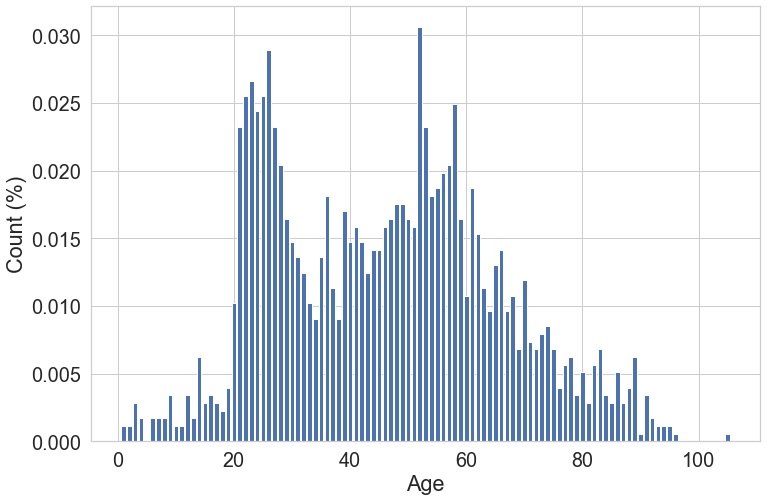

In [31]:
# use barplot to show the age distribution

plt.figure(figsize = (12, 8))
plt.bar(feat_count.index, feat_count.values)
plt.xlabel('Age')
plt.ylabel('Count (%)')
plt.show()

In [32]:
# impute with random choice using 16 values with equal weights
# one can elaborate on this by generating two gaussian ensembles with means of 25 and 55 respectively

list_feat = [21.0, 22.0, 23.0, 24.0, 25.0, 27.0, 28.0, 29.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 58.0, 60.0]
weights_feat = np.ones(16) / 16

df.loc[df[feat].isna(), feat] = choice(list_feat, p = weights_feat, size = df[feat].isna().sum())

In [33]:
# check value count again including nulls

print(df[feat].value_counts(dropna = False))

27.0     79
23.0     78
58.0     78
25.0     76
24.0     73
         ..
93.0      2
94.0      2
96.0      1
105.0     1
90.0      1
Name: n_age, Length: 96, dtype: int64


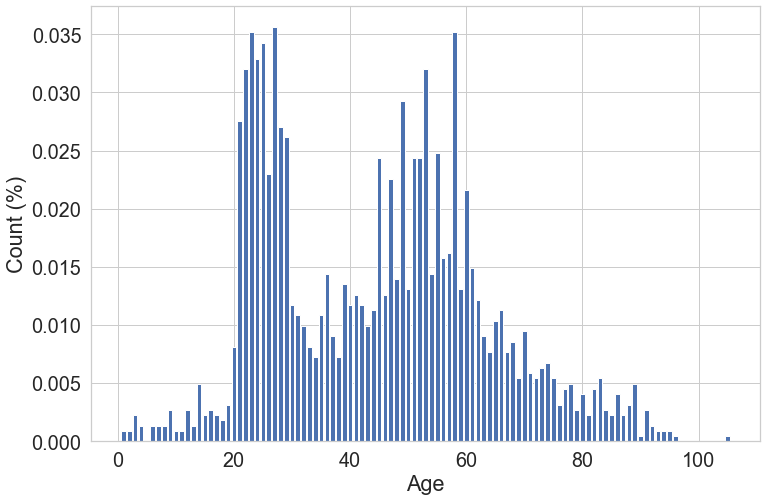

In [34]:
# use the barplot again

feat_count = df[feat].value_counts(normalize = True)

plt.figure(figsize = (12, 8))
plt.bar(feat_count.index, feat_count.values)
plt.xlabel('Age')
plt.ylabel('Count (%)')
plt.show()

 **<font color='teal'> Check for any remaining null values.</font>**

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       2218 non-null   float64
 1   sex              2218 non-null   object 
 2   country          2218 non-null   object 
 3   province         2218 non-null   object 
 4   city             2218 non-null   object 
 5   disease          2218 non-null   object 
 6   infection_case   2218 non-null   object 
 7   infection_order  2218 non-null   float64
 8   infected_by      2218 non-null   float64
 9   contact_number   2218 non-null   float64
 10  state            2130 non-null   object 
 11  n_age            2218 non-null   float64
dtypes: float64(5), object(7)
memory usage: 208.1+ KB


As already discussed, after the imputation only the target 'state' is left with missing values. We will create two new datasets, df_model (no missing values for 'state') and df_prediction (only missing values for 'state'), respectively.

In [36]:
mask_na = df['state'].isna()

df_model = df[~mask_na] # no missing values
df_pred = df[mask_na] # missing values

In [37]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2217
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       2130 non-null   float64
 1   sex              2130 non-null   object 
 2   country          2130 non-null   object 
 3   province         2130 non-null   object 
 4   city             2130 non-null   object 
 5   disease          2130 non-null   object 
 6   infection_case   2130 non-null   object 
 7   infection_order  2130 non-null   float64
 8   infected_by      2130 non-null   float64
 9   contact_number   2130 non-null   float64
 10  state            2130 non-null   object 
 11  n_age            2130 non-null   float64
dtypes: float64(5), object(7)
memory usage: 216.3+ KB


In [38]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 802 to 2213
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       88 non-null     float64
 1   sex              88 non-null     object 
 2   country          88 non-null     object 
 3   province         88 non-null     object 
 4   city             88 non-null     object 
 5   disease          88 non-null     object 
 6   infection_case   88 non-null     object 
 7   infection_order  88 non-null     float64
 8   infected_by      88 non-null     float64
 9   contact_number   88 non-null     float64
 10  state            0 non-null      object 
 11  n_age            88 non-null     float64
dtypes: float64(5), object(7)
memory usage: 8.9+ KB


Review the count of unique values of df_model by column.

In [39]:
print(df_model.nunique())

global_num         1224
sex                   2
country               4
province             17
city                133
disease               2
infection_case       16
infection_order       7
infected_by         196
contact_number       73
state                 3
n_age                96
dtype: int64


Review the percent of unique values by column.

In [40]:
print(df_model.nunique()/df_model.shape[0])

global_num         0.574648
sex                0.000939
country            0.001878
province           0.007981
city               0.062441
disease            0.000939
infection_case     0.007512
infection_order    0.003286
infected_by        0.092019
contact_number     0.034272
state              0.001408
n_age              0.045070
dtype: float64


Review the range of values per column.

In [41]:
df_model.describe().T

,count,mean,std,min,25%,50%,75%,max
global_num,2130.0,4.526484e+03,2.137668e+03,1.000000e+00,4.051250e+03,4.664820e+03,5.445500e+03,8.717000e+03
infection_order,2130.0,2.289915e+00,1.741546e-01,1.000000e+00,2.290000e+00,2.290000e+00,2.290000e+00,6.000000e+00
infected_by,2130.0,2.620626e+09,7.269510e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2130.0,2.414635e+01,3.996888e+01,0.000000e+00,2.413000e+01,2.413000e+01,2.413000e+01,1.160000e+03
n_age,2130.0,4.448826e+01,1.874506e+01,1.000000e+00,2.700000e+01,4.500000e+01,5.800000e+01,1.050000e+02


### Check for duplicated rows

In [42]:
duplicateRowsDF = df_model[df_model.duplicated()]
duplicateRowsDF

,global_num,sex,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
1059,4664.82,male,Korea,Chungcheongnam-do,Seosan-si,0,contact with patient,2.29,4.100000e+09,2.00,isolated,54.0
1609,4664.82,male,Korea,Gyeongsangbuk-do,Gyeongsan-si,0,contact with patient,2.29,2.600789e+09,24.13,isolated,58.0
1635,4664.82,female,Korea,Gyeongsangbuk-do,Goryeong-gun,0,contact with patient,2.29,2.600789e+09,24.13,isolated,29.0
1650,4664.82,male,Korea,Gyeongsangbuk-do,Gumi-si,0,contact with patient,2.29,2.600789e+09,24.13,isolated,58.0
1653,4664.82,female,Korea,Gyeongsangbuk-do,Gumi-si,0,contact with patient,2.29,2.600789e+09,24.13,isolated,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2050,4664.82,male,Korea,Gyeongsangbuk-do,Chilgok-gun,0,contact with patient,2.29,2.600789e+09,24.13,isolated,38.0
2053,4664.82,female,Korea,Gyeongsangbuk-do,Chilgok-gun,0,contact with patient,2.29,2.600789e+09,24.13,isolated,48.0
2062,4664.82,male,Korea,Gyeongsangbuk-do,Chilgok-gun,0,contact with patient,2.29,2.600789e+09,24.13,released,26.0
2079,4664.82,male,Korea,Gyeongsangbuk-do,Chilgok-gun,0,contact with patient,2.29,2.600789e+09,24.13,isolated,66.0


Print the categorical columns and their associated levels.

In [43]:
dfo = df_model.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,133
4,disease,2
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

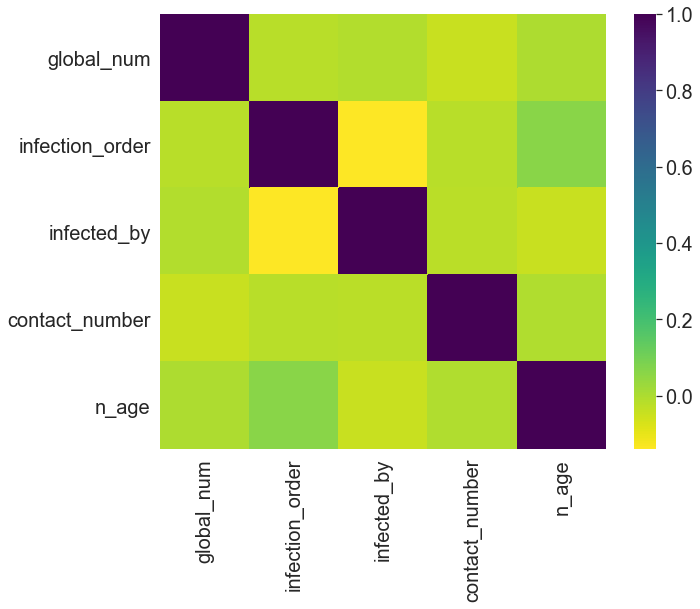

In [44]:
plt.figure(figsize = (10, 8))
sns.heatmap(df_model.corr(), cmap = 'viridis_r')
plt.tick_params(labelsize = 20)
plt.show()

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [45]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2217
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       2130 non-null   float64
 1   sex              2130 non-null   object 
 2   country          2130 non-null   object 
 3   province         2130 non-null   object 
 4   city             2130 non-null   object 
 5   disease          2130 non-null   object 
 6   infection_case   2130 non-null   object 
 7   infection_order  2130 non-null   float64
 8   infected_by      2130 non-null   float64
 9   contact_number   2130 non-null   float64
 10  state            2130 non-null   object 
 11  n_age            2130 non-null   float64
dtypes: float64(5), object(7)
memory usage: 216.3+ KB


In [46]:
# define function to create boxplot for each feature vs. 'state'
feat = 'global_num'

def feat_boxplot(feat):
    plt.figure(figsize = (10, 6))
    sns.boxplot(x = df_model['state'], y = df_model[feat], palette = 'viridis')
    plt.show()

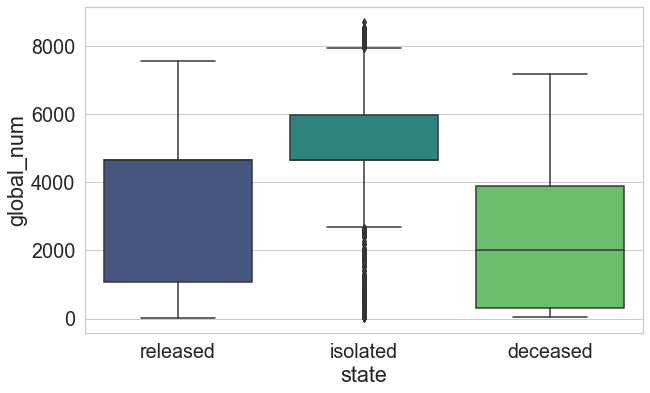

In [47]:
# global_num boxplot
feat = 'global_num'
feat_boxplot(feat)

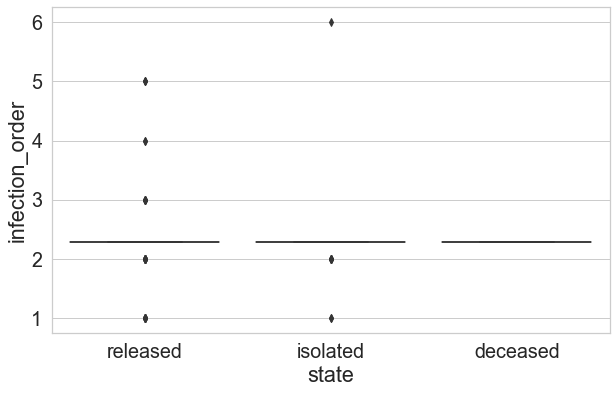

In [48]:
# infection_order boxplot
feat = 'infection_order'
feat_boxplot(feat)

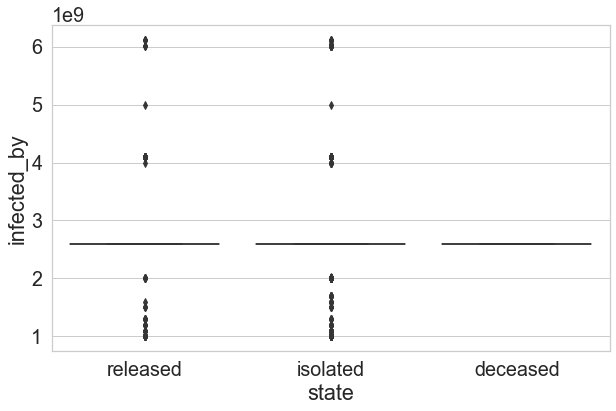

In [49]:
# infected_by boxplot
feat = 'infected_by'
feat_boxplot(feat)

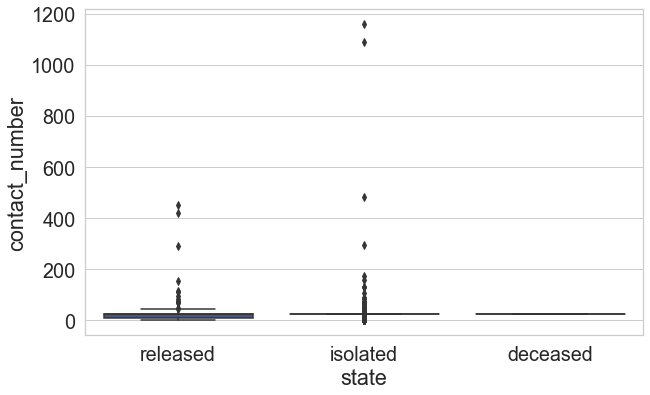

In [50]:
# contact_number boxplot
feat = 'contact_number'
feat_boxplot(feat)

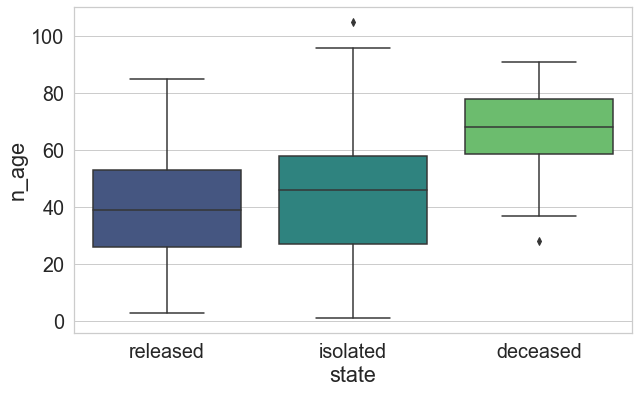

In [51]:
# n_age boxplot
feat = 'n_age'
feat_boxplot(feat)

**<font color='teal'> Create dummy features for object type features. </font>**

In [52]:
df_m = df_model.copy()

In [53]:
# replace 'state' categorical value with numeric categorical values

feat = 'state'

count_feat = df_m[feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))

isolated    84.08
released    14.41
deceased     1.50
Name: state, dtype: float64


In [54]:
# create a dictionary to replace current non-numerical values
dict_feat = {count_feat.index[i]:(i+1) for i in range(len(count_feat))}

print(dict_feat)

{'isolated': 1, 'released': 2, 'deceased': 3}


In [55]:
# Replace the current categorical values with numerical categorical values --> modeling data
df_m[feat].replace(dict_feat, inplace=True)

# check
print(df_m[feat].value_counts().index)

Int64Index([1, 2, 3], dtype='int64')


In [56]:
df_m.columns

Index(['global_num', 'sex', 'country', 'province', 'city', 'disease',
       'infection_case', 'infection_order', 'infected_by', 'contact_number',
       'state', 'n_age'],
      dtype='object')

In [57]:
# create X and y
features = ['global_num', 'sex', 'country', 'province', 'city', 'disease', 'infection_case', 
            'infection_order', 'infected_by', 'contact_number', 'n_age']

X = df_m[features]
y = df_m['state']

In [58]:
# create dummies
X = pd.get_dummies(X)

### Split the data into test and train subsamples

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [60]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [61]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [62]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.864
Random Forest: f1-score=0.851


### Obtain Confusion Matrix and Classification Report
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [63]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred))

Confusion Matrix:
[[346  19   0]
 [ 38  16   0]
 [  1   0   6]]


Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.95      0.92       365
           2       0.46      0.30      0.36        54
           3       1.00      0.86      0.92         7

    accuracy                           0.86       426
   macro avg       0.79      0.70      0.74       426
weighted avg       0.84      0.86      0.85       426



### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


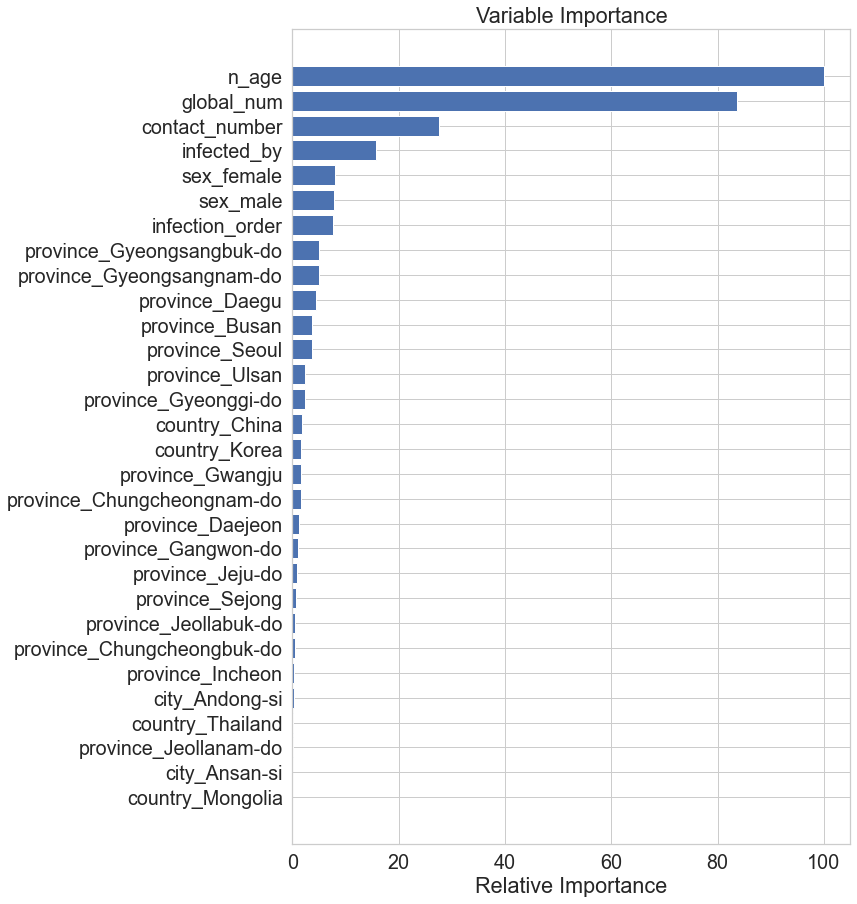

In [64]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.